# 03 - 统计回顾：最危险的方程

霍华德·韦纳（Howard Wainer）在其 2007 年的著名文章中论述了一些极其危险的方程：

“有些方程的危险在于你知晓它们，而另一些的危险则在于你对其一无所知。前者之所以构成威胁，是因为其内涵的秘密会打开通往隐藏巨大灾难的大门。其中显而易见的代表是爱因斯坦的标志性方程 $E = mc^2$，它揭示了潜藏于寻常物质中的巨大能量。相反，我关注的是那些当我们不了解时才释放其危险性的方程。这些方程若常备于心，能助我们洞悉事理；但若缺失，则会使我们陷入危险的无知境地。”

他所指的方程是棣莫弗方程：

$
SE = \dfrac{\sigma}{\sqrt{n}} 
$

其中 $SE$ 代表均值的标准误差，$\sigma$ 为标准差，$n$ 为样本容量。这听起来像是求真敢为者应当掌握的数学知识，让我们开始学习吧。

为了说明不了解这个公式为何极其危险，我们来看一些教育数据。我整理了三年间不同学校的 ENEM 成绩（巴西标准化高中考试分数，类似 SAT），并清理数据仅保留相关部分。原始数据可在 [Inep 官网](http://portal.inep.gov.br/web/guest/microdados#)下载。

观察表现最优的学校时，有一点引人注目：这些学校的学生数量相对较少。

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

In [2]:
df = pd.read_csv("data/enem_scores.csv")
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


换一个角度来看，我们可以仅分离出前 1%的顶尖学校进行研究。它们有何特点？或许我们能从这些佼佼者身上学到些什么，并在其他地方复制其成功经验。果然，当我们观察这前 1%的学校时，发现它们平均而言学生数量较少。

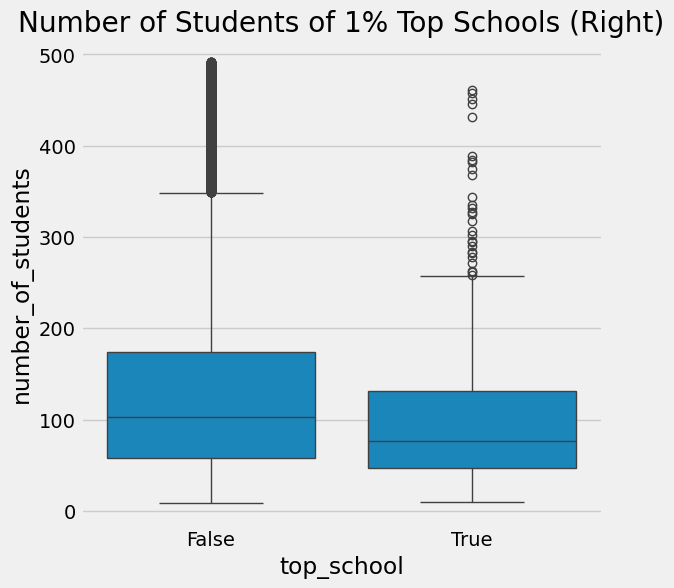

In [3]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(6,6))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)");

一个自然而然的结论是，小规模学校能带来更高的学业表现。这在直觉上说得通，因为我们相信每位教师对应的学生越少，教师就能给予每个学生更多关注。但这与棣莫弗方程有何关联？又为何说这种做法存在风险？

然而，一旦人们开始依据这些信息做出重要且代价高昂的决策，情况就变得危险了。霍华德在文章中继续写道：

“20 世纪 90 年代，提倡缩小学校规模的做法盛行一时。众多慈善组织和政府机构资助拆分大型学校，因为小规模学校的学生在考试成绩优异群体中占比过高。”

人们却忽视了去关注成绩最差的 1%学校。当我们这样做时，瞧！这些学校的学生人数同样寥寥无几！

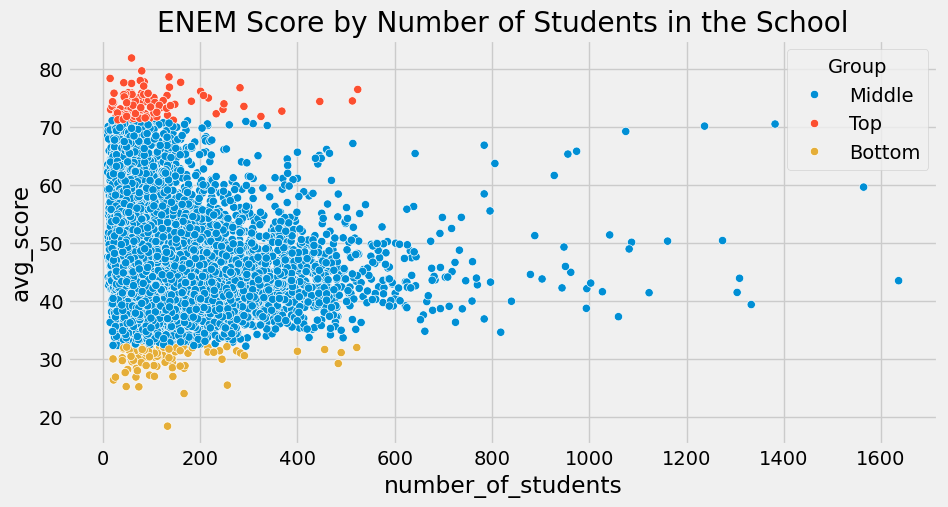

In [4]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([d["avg_score"] > q_99, d["avg_score"] < q_01],
                                                 ["Top", "Bottom"], "Middle")))
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", hue="Group", data=plot_data)
plt.title("ENEM Score by Number of Students in the School");

上述现象正是莫瓦方程（Moivre’s equation）所预期的现象：随着学生人数的增加，平均成绩变得越来越精确。学校如果样本量很小，就可能因为纯粹的随机性而出现极高或极低的分数，这种情况在大规模学校中就不太可能发生。莫瓦方程揭示了一个关于现实中信息与数据记录的基本事实：数据永远是不精确的。那么问题就变成：它到底有多不精确？

统计学是一门处理这些不精确性的科学，以确保我们不会措手不及。正如塔勒布在其著作《被随机性欺骗》中所言：

> 概率不仅仅是对骰子或更复杂变体胜率的计算；它是对我们知识中确定性缺失的接纳，以及发展出应对无知的方法。

量化我们不确定性的一种方式是通过**估计值的方差**。方差告诉我们观测值与其中心及最可能值之间的偏离程度。正如莫瓦方程所示，这种不确定性随着我们观察数据量的增加而减小。这很合理，对吧？如果我们看到一所学校有许多学生表现优异，我们就能更有信心认为这确实是一所好学校。然而，如果我们看到一所学校仅有 10 名学生，其中 8 名表现良好，我们就需要更加怀疑。可能只是偶然，这所学校招到了一些高于平均水平的学生。

上方那幅美丽的三角形图正好讲述了这个故事。它展示出，当样本量很小时，我们对学校表现的估计具有极大的方差；而随着样本量的增加，这种方差逐渐缩小。这种现象不仅适用于学校的平均成绩，同样也适用于我们手中拥有的任何汇总统计量，包括我们常常希望估计的平均处理效应（ATE）。

##  估计值的标准误差

由于这仅是对统计学的回顾，我将适当加快讲解节奏。若您对分布、方差及标准误等概念尚不熟悉，请继续阅读，但需注意可能需要额外参考资料。建议您搜索麻省理工学院（MIT）的任何统计学入门课程，这些课程通常都讲得非常不错。

在前一节中，我们通过比较处理组与未处理组的均值差异（$E[Y|T=1]-E[Y|T=0]$），估计了平均处理效应 $E[Y_1-Y_0]$  。以在线课程为例，我们计算出了 $ATE$，并观察到负面影响：在线课程使学生成绩比面授课程学生低约 5 分。现在，我们将检验这一影响是否具有统计学显著性。

为此，我们需要估计 $SE$。已知样本量 $n$，为计算标准差的估计值，可采用如下方法：

$$
\hat{\sigma}=\sqrt{\frac{1}{N-1}\sum_{i=1}^N (x_i-\bar{x})^2}
$$

其中 $\bar{x}$ 是 $x$ 的平均值。幸运的是，大多数编程软件已经实现了这一点。在 Pandas 中，我们可以使用 [std](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.std.html) 方法。

In [5]:
data = pd.read_csv("./data/online_classroom.csv")
online = data.query("format_ol==1")["falsexam"]
face_to_face = data.query("format_ol==0 & format_blended==0")["falsexam"]

def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Online:", se(online))
print("SE for Face to Face:", se(face_to_face))

SE for Online: 1.5371593973041635
SE for Face to Face: 0.8723511456319104


## 置信区间

我们估计的标准误差是衡量置信度的一个指标。为了准确理解其含义，我们需要深入探讨充满争议且复杂的统计学领域。从统计学的一种观点——频率学派的视角来看，我们会认为数据不过是精确数据生成过程的表现形式。这个过程抽象而理想，由真实且恒定的参数所支配，但这些参数对我们而言却是未知的。以学生测试为例，如果我们能进行多次实验并收集多个数据集，所有这些数据集都会近似于真实的数据生成过程，但不会与之完全相同。这与柏拉图关于“理念”（Forms）的论述极为相似：

> 每一个本质的理念（essential form），都在与行为、与物质事物、以及彼此之间的各种组合中呈现出来，每一个理念看起来仿佛是多样的、纷繁的。

为了更好地理解这个概念，假设我们有一个学生考试成绩的真实抽象分布。这个分布是一个均值为 74、标准差为 2 的正态分布。基于这个分布，我们可以进行 10,000 次实验，每次从中抽取 500 个样本。如果我们将这些实验中每次的样本均值绘制成直方图，就会发现它们围绕着真实均值呈现分布。有些实验的样本均值会低于真实均值，而有些则会高于真实均值。

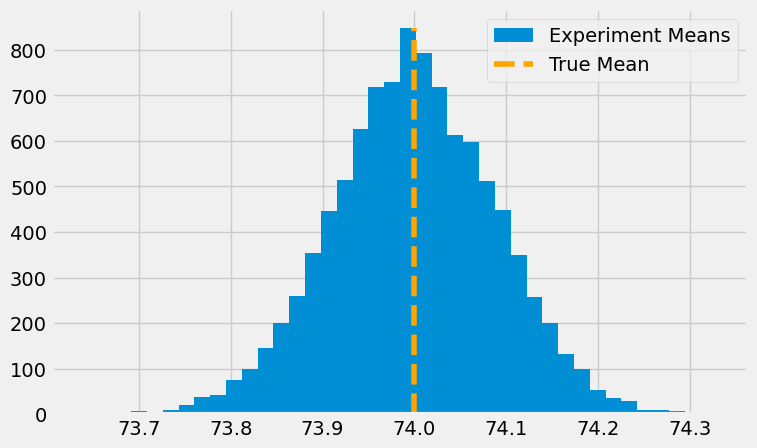

In [6]:
true_std = 2
true_mean = 74

n = 500
def run_experiment(): 
    return np.random.normal(true_mean,true_std, 500)

np.random.seed(42)

plt.figure(figsize=(8,5))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=40, label="Experiment Means")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="orange")
plt.legend();

要注意，我们这里讨论的是“均值的均值”。也就是说，由于随机性，我们可能会遇到某次实验的样本均值略低于或略高于真实的均值。换句话说，我们永远无法确定某次实验得到的样本均值就恰好等于那个柏拉图式、理想化的真实均值。不过，**借助标准误（standard error），我们可以构造一个置信区间，这个区间在 95% 的情况下会包含真实均值**。

现实中，我们无法奢侈地用多个数据集重复模拟同一实验，通常仅有一个数据集可用。但我们可以借鉴上述思路来构建所谓的**置信区间**。置信区间附带有概率指标，最常见的是 95%置信度。这一概率表明，在不同研究中构建的假设性置信区间有多少能包含真实均值。例如，基于类似研究计算的 95%置信区间，将有 95%的几率涵盖真实均值。

为计算置信区间，我们采用**中心极限定理**。该定理指出，实验**均值的分布服从正态分布**。根据统计学理论，我们已知正态分布 95%的质量集中于均值上下两个标准差范围内。严格而言应为 1.96 倍标准差，但近似取 2 已足够精确。

![normal_density](./images/16/normal_dist.jpeg)

均值标准误可作为实验均值分布的估计量。因此，若将其乘以 2 后与单次实验均值相加减，即可构建出真实均值 95%置信区间。

In [7]:
np.random.seed(321)
exp_data = run_experiment()
exp_se = exp_data.std() / np.sqrt(len(exp_data))
exp_mu = exp_data.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print(ci)

(73.82718114045632, 74.17341543460314)


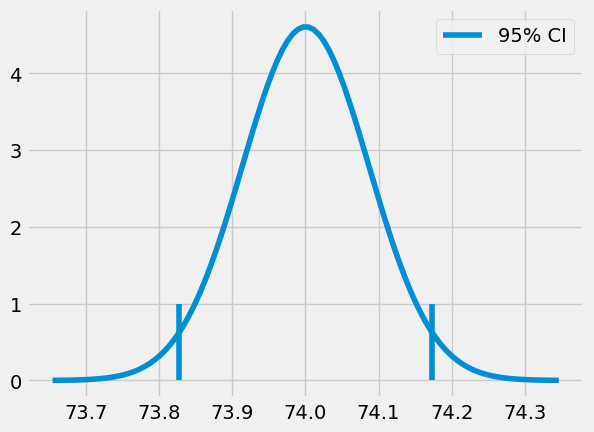

In [8]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="95% CI")
plt.legend()
plt.show()

当然，我们不必局限于 95%的置信区间。通过确定需要将标准差乘以多少才能使区间包含正态分布 99%的质量，我们可以生成 99%的区间。

Python 中的函数 `ppf` 提供了累积分布函数（CDF）的逆运算。不同于我们为求 95%置信区间（CI）时将标准误差乘以 2 的做法，此处我们将乘以 `z` ，从而得到 99%的置信区间。因此， `ppf(0.5)` 将返回 0.0，表明标准正态分布（均值为 0，标准差为 1）中有 50%的质量位于 0.0 以下。同理，若输入 99.5%，我们将得到值 `z` ，这意味着 99.5%的分布质量低于此值。换言之，仅有 0.5%的质量高于该值。

In [9]:
from scipy import stats
z = stats.norm.ppf(.995)
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(73.7773381773405, 74.22325839771896)

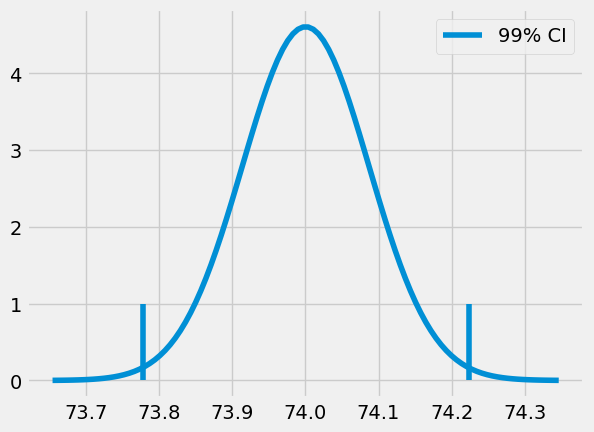

In [10]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="99% CI")
plt.legend()
plt.show()

回到我们的课堂实验，我们可以为在线和面对面学生群体的平均考试成绩构建置信区间

In [11]:
def ci(y: pd.Series):
    return (y.mean() - 2 * se(y), y.mean() + 2 * se(y))

print("95% CI for Online:", ci(online))
print("95% for Face to Face:", ci(face_to_face))

95% CI for Online: (70.56094429049804, 76.7095818797147)
95% for Face to Face: (76.80278229206951, 80.29218687459715)


我们可以观察到，各组的 95%置信区间（CI）并未重叠。面对面授课班级 CI 的下限高于在线课程 CI 的上限。这一结果表明，我们的发现并非偶然，且面对面课堂学生的真实均值确实高于在线课程学生。换言之，从面对面教学转向在线课程会导致学业成绩出现显著的因果性下降。

概括而言，置信区间是为我们的估计值提供不确定性范围的一种方法。样本量越小，标准误差越大，置信区间也越宽。由于置信区间计算极为简便，未提供置信区间可能意味着存在不良意图或仅仅是知识匮乏，这两者同样令人担忧。最后，对于没有任何不确定性度量的测量结果，你应始终保持怀疑态度。

![img](images/16/ci_xkcd.png)

最后要提醒一点，置信区间的解读比初看起来更为复杂。例如，我`不能`说这个特定的 95%置信区间有 95%的概率包含真实的总体均值。在使用置信区间的频率统计中，总体均值被视为一个固定的真实总体参数。因此，它要么在我们特定的置信区间内，要么不在。换句话说，我们具体的置信区间要么包含真实均值，要么不包含。如果包含，那么包含的概率就是 100%，而非 95%；如果不包含，概率则为 0%。实际上，置信区间中的 95%指的是在多次研究中计算出的此类置信区间包含真实均值的频率。95%是我们对用于计算 95%置信区间的算法的信心，而非针对某个特定区间本身。

话虽如此，作为一名经济学家（统计学家们现在可以回避了），我认为这种纯粹主义并无太大实际意义。在实践中，你会听到人们说特定置信区间在 95%的情况下包含真实均值。尽管这种表述并不准确，但它并无大碍，因为它依然为我们的估计设定了一个明确的不确定性程度。此外，如果我们转向贝叶斯统计并使用概率区间而非置信区间，我们就能说该区间在 95%的情况下包含分布均值。而且根据我的实际观察，在样本量足够的情况下，贝叶斯概率区间与置信区间的相似度，比贝叶斯学派和频率学派愿意承认的要高得多。因此，如果我的意见有任何分量，你大可以随心所欲地描述你的置信区间。即便你说它们在 95%的情况下包含真实均值，我也不介意。但请永远记得将区间估计值标注出来，否则你会显得很可笑。


## 假设检验

另一种纳入不确定性的方法是陈述一个假设检验：均值差异在统计上是否显著不同于零（或任何其他值）？我们将回顾，两个独立正态分布的和或差也是正态分布。所得均值将是两个分布的和或差，而方差始终是两者方差之和：

$
N(\mu_1, \sigma_1^2) - N(\mu_2, \sigma_2^2) = N(\mu_1 - \mu_2, \sigma_1^2 + \sigma_2^2)
$

$
N(\mu_1, \sigma_1^2) + N(\mu_2, \sigma_2^2) = N(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)
$

如果你不记得了也没关系。我们总可以用代码和模拟数据来验证：

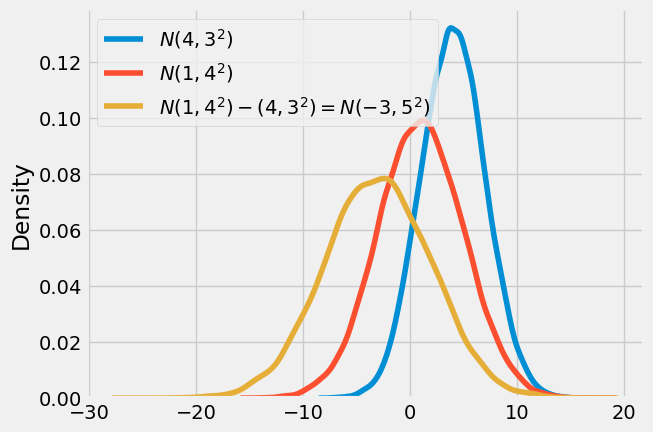

In [12]:
np.random.seed(123)
n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1
sns.distplot(n1, hist=False, label="$N(4,3^2)$")
sns.distplot(n2, hist=False, label="$N(1,4^2)$")
sns.distplot(n_diff, hist=False, label=f"$N(1,4^2) - (4,3^2) = N(-3, 5^2)$")
plt.legend()
plt.show()

如果我们取两组均值的分布并将一个减去另一个，将得到第三个分布。这个最终分布的均值将是两组均值的差异，而其标准差则是各标准差之和的平方根。

$
\mu_{diff} = \mu_1 - \mu_2
$

$
SE_{diff} = \sqrt{SE^2_1 + SE^2_2} = \sqrt{\sigma_1^2/n_1 + \sigma_2^2/n_2}
$

让我们回到课堂的例子。我们将构建这个差异的分布。当然，一旦有了这个分布，构建 95%的置信区间就变得简单直接了。

In [13]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(ci)

(-8.376410208363385, -1.4480327880905248)


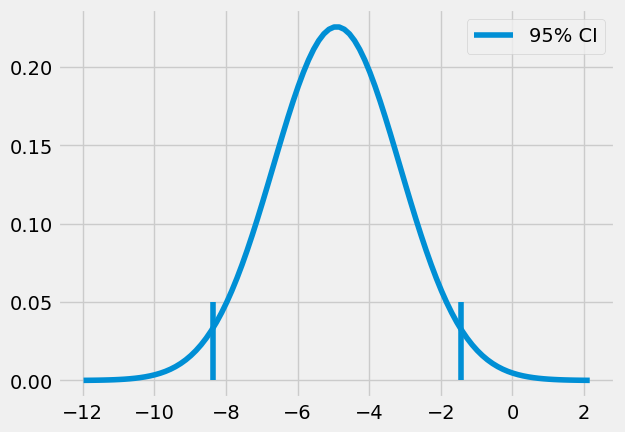

In [14]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=.05)
plt.vlines(ci[0], ymin=0, ymax=.05, label="95% CI")
plt.legend()
plt.show()

有了这个数据，我们可以有 95%的把握认为在线组与面对面组之间的真实差异落在-8.37 到-1.44 之间。此外，我们还可以通过将均值差除以差异的 $SE$ 来构建一个 **z 统计量**。

$
z = \dfrac{\mu_{diff} - H_{0}}{SE_{diff}} = \dfrac{(\mu_1 - \mu_2) - H_{0}}{\sqrt{\sigma_1^2/n_1 + \sigma_2^2/n_2}}
$

其中 $H_0$ 是我们想要测试差异的基准值。

z 统计量是衡量观察到的差异极端程度的指标。我们将采用反证法来检验均值差异在统计上是否显著不为零的假设。首先，我们假设相反的情况成立，即差异为零，这被称为零假设或 $H_0$。接着，我们自问：“如果真实差异为零，观察到如此大差异的可能性有多大？”用统计学术语来说，这个问题可转化为检验我们的 z 统计量距离零有多远。

在 $H_0$条件下，z 统计量服从标准正态分布。因此，若差异确实为零，我们有 95%的概率观察到 z 统计量位于均值两侧 2 个标准差范围内。其直接推论是，若 z 值超出 ±2 个标准差范围，我们就能以 95%的置信度拒绝零假设。

让我们看看这在我们课堂示例中是什么样子。

In [15]:
z = diff_mu / diff_se
print(z)

-2.7792810791031224


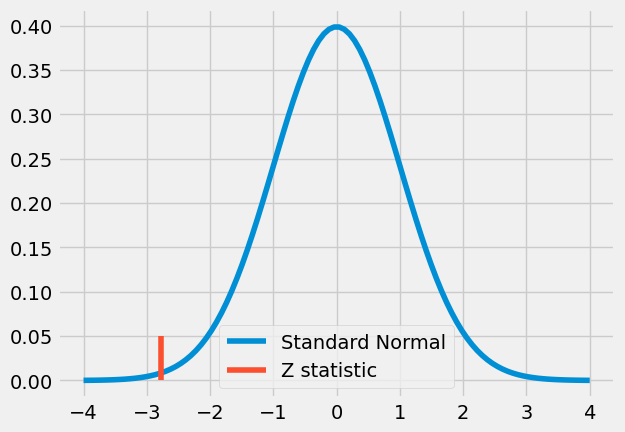

In [16]:
x = np.linspace(-4,4,100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, label="Standard Normal")
plt.vlines(z, ymin=0, ymax=.05, label="Z statistic", color="C1")
plt.legend()
plt.show()

这个数值看起来相当极端。实际上，它超过了 2，这意味着如果两组之间没有差异，我们观察到如此极端值的概率将低于 5%。这再次引导我们得出结论：从面对面授课转为在线课程会导致学术成绩在统计上显著下降。

关于假设检验最后一件有趣的事情是，它比检查处理组和未处理组的 95%置信区间是否重叠更为宽松。换言之，即便两组间的置信区间存在重叠，结果仍可能在统计学上显著。例如，假设面对面组的平均得分为 80，标准误差为 4，而在线组的平均得分为 71，标准误差为 2。

In [17]:
cont_mu, cont_se =  (71, 2)
test_mu, test_se = (80, 4)

diff_mu = test_mu - cont_mu
diff_se = np.sqrt(cont_se**2 + test_se**2)

print("Control 95% CI:", (cont_mu-1.96*cont_se, cont_mu+1.96*cont_se))
print("Test 95% CI:", (test_mu-1.96*test_se, test_mu+1.96*test_se))
print("Diff 95% CI:", (diff_mu-1.96*diff_se, diff_mu+1.96*diff_se))

Control 95% CI: (67.08, 74.92)
Test 95% CI: (72.16, 87.84)
Diff 95% CI: (0.23461352820082482, 17.765386471799175)


如果我们为这些组构建置信区间，它们会相互重叠。在线组的 95%置信区间上限为 74.92，而面对面组的下限为 72.16。然而，一旦我们计算两组间差异的 95%置信区间，就会发现该区间不包含零。尽管各自的置信区间有重叠，差异仍可能在统计上显著不为零。

## P-values

此前我曾提到，如果线上与面对面小组之间的差异实际为零，我们观察到如此极端值的概率不足 5%。但我们能否精确估算这一概率？观察到如此极端值的可能性究竟有多大？这就引入了 p 值！

与置信区间（事实上，大多数频率统计方法也是如此）一样，p 值的真实定义可能非常令人困惑。因此，为了不冒任何风险，我将引用维基百科上的定义：“p 值是在假设零假设正确的前提下，获得至少与实际观测到的测试结果一样极端的测试结果的概率”。

简而言之，p 值是在零假设为真的情况下观察到此类数据的概率。它衡量的是在零假设成立时，你所看到的测量结果有多么不可能。很自然地，这常常被误认为是零假设为真的概率。请注意这里的区别：p 值并非 $P(H_0|data)$，而是 $P(data|H_0)$。

但别被这种复杂性所迷惑。实际上，它们使用起来相当简单直接。

![p_value](./images/16/p_value.png)

要获得 p 值，我们需要计算标准正态分布在 z 统计量之前或之后的面积。幸运的是，我们可以借助计算机来完成这一计算。只需将 z 统计量代入标准正态分布的累积分布函数(CDF)中即可。

In [18]:
print("P-value:", stats.norm.cdf(z))

P-value: 0.0027239680835563383


注意到 p 值的有趣之处在于它使我们无需指定如 95%或 99%这样的置信水平。然而，如果我们希望报告一个置信水平，通过 p 值，我们可以精确知道在哪个置信度下我们的检验会通过或失败。例如，当 p 值为 0.0027 时，我们发现显著性水平可达 0.2%。因此，虽然差异的 95%置信区间和 99%置信区间都不会包含零，但 99.9%的置信区间会包含零。这意味着如果差异为零，观察到如此极端的 z 统计量仅有 0.2%的概率。

In [19]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
print("95% CI:", (diff_mu - stats.norm.ppf(.975)*diff_se, diff_mu + stats.norm.ppf(.975)*diff_se))
print("99% CI:", (diff_mu - stats.norm.ppf(.995)*diff_se, diff_mu + stats.norm.ppf(.995)*diff_se))
print("99.9% CI:", (diff_mu - stats.norm.ppf(.9995)*diff_se, diff_mu + stats.norm.ppf(.9995)*diff_se))

95% CI: (-8.376346553082909, -1.4480964433710017)
99% CI: (-9.46485353526404, -0.3595894611898709)
99.9% CI: (-10.728040658245558, 0.9035976617916468)


## 核心要点

我们已了解掌握棣莫弗方程的重要性，并运用它为我们的估计赋予了一定程度的确定性。具体而言，我们发现与面对面授课相比，在线课程会导致学业成绩下降。同时，这一结果在统计学上具有显著性。我们通过比较两组均值的置信区间、观察差异的置信区间、进行假设检验以及查看 p 值来完成这一分析。现在，让我们将所有步骤整合到一个函数中，以便执行类似上述的 A/B 测试比较。

In [20]:
def AB_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0):
    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))
    
    diff = mu1 - mu2
    se_diff = np.sqrt(test.var()/len(test) + control.var()/len(control))
    
    z_stats = (diff-h0)/se_diff
    p_value = stats.norm.cdf(z_stats)
    
    def critial(se): return -se*stats.norm.ppf((1 - confidence)/2)
    
    print(f"Test {confidence*100}% CI: {mu1} +- {critial(se1)}")
    print(f"Control {confidence*100}% CI: {mu2} +- {critial(se2)}")
    print(f"Test-Control {confidence*100}% CI: {diff} +- {critial(se_diff)}")
    print(f"Z Statistic {z_stats}")
    print(f"P-Value {p_value}")
        
AB_test(online, face_to_face)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.7792810791031224
P-Value 0.0027239680835563383


由于我们的函数足够通用，可以测试其他零假设。例如，我们能否尝试否定在线课程与面对面课程表现之间的差异为-1？根据所得结果，我们可以有 95%的把握说差异比-1 更为显著。但我们无法以 99%的置信度断言这一点：

In [21]:
AB_test(online, face_to_face, h0=-1)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.2134920404560883
P-Value 0.013431870694630116


## 参考文献
我愿将这一系列作品视为对 Joshua Angrist、Alberto Abadie 和 Christopher Walters 杰出计量经济学课程的致敬。第一部分的大部分思想源自他们在美国经济学会授课的内容。在艰难的 2020 年，正是观看他们的课程视频让我保持了理智。

 - [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
 - [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

 我还想引用 Angrist 的精彩著作。它们向我展示了计量经济学（他们称之为“Metrics”）不仅极为实用，而且充满乐趣。
 - [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com)
 - [Mastering ‘Metrics](https://www.masteringmetrics.com)

最后还要感谢 Miguel Hernán 和 Jamie Robins 的[《Causal Inference》](https://hsph.harvard.edu/profile/miguel-hernan/)一书。它是我在面对最棘手的因果问题时的可靠伙伴。

![img](./images/poetry.png)

## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。